Определим триггеры, на которые пользователи вообще не отреагировали

In [6]:
import ibis
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
con = ibis.duckdb.connect()

In [8]:
# Загрузка таблиц
triggers = con.read_csv('data/triggers.csv')  # Замените на путь к вашей таблице triggers
new_actions = con.read_csv('data/new_actions.csv')

In [9]:
unique_triggers = triggers.filter(~triggers['trigger'].isin(new_actions['trigger']))

In [10]:
unique_triggers.head(10).execute()

,guid,date,trigger,type
0,0187a17e-6398-7777-cdd5-db79fd6734fd,2024-05-31 16:10:34,2265,3
1,018c2575-bb0d-ced6-5813-24972c98039d,2024-05-31 16:10:32,534,1
2,01879a34-b716-a6fd-eea4-a1048c3592c3,2024-05-31 16:10:32,503,1
3,01879241-6019-a3d3-0590-0105ac42d9b6,2024-05-31 16:10:30,2227,1
4,018c2575-bb0d-ced6-5813-24972c98039d,2024-05-31 16:10:30,534,1
5,018ba1cb-6529-5f86-a626-d79924d3a4f6,2024-05-31 16:10:27,749,1
6,01884374-c374-0861-cae2-fdecec542458,2024-05-31 16:10:26,144,1
7,01879eb5-5f88-7895-2572-56bd0d51fd10,2024-05-31 16:10:26,2267,1
8,018ba12d-8e9b-159d-aef0-a293e0885141,2024-05-31 16:05:34,2077,2
9,018ba16a-22e6-9c8b-8b3f-c3e6ee4b6681,2024-05-31 16:00:32,739,1


In [11]:
useless_triggers = unique_triggers.execute().trigger.unique()

In [12]:
useless_triggers.shape

(1316,)

Получаем 1316 триггеров, на которые пользователи никак не отреагировали

In [13]:
usefull_triggers = new_actions.execute().trigger.unique()

In [14]:
usefull_triggers.shape

(1191,)

Получаем 1191 уникальный триггер, на которые пользователи отреагировали 

Определим количество триггеров, с которыми пользователи совершили положительное действие

In [15]:
new_actions = new_actions.execute()

In [16]:
positive_triggers = new_actions.loc[new_actions['result'] == 1, 'trigger'].unique()

In [17]:
positive_triggers.shape[0]

523

Получаем 523 уникальных триггера, с которыми пользователи совершили положительные действия

Построим графики для времени суток

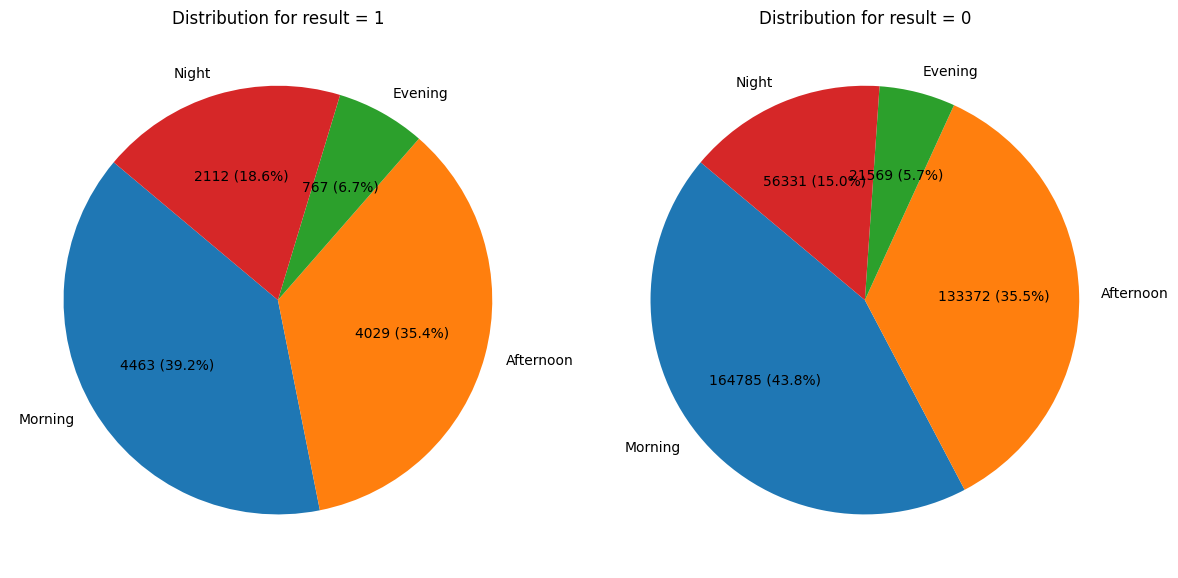

In [18]:
data_result_1 = new_actions[new_actions["result"] == 1]
data_result_0 = new_actions[new_actions["result"] == 0]

time_counts_1 = [
    data_result_1["morning"].sum(),
    data_result_1["afternoon"].sum(),
    data_result_1["evening"].sum(),
    data_result_1["night"].sum(),
]

time_counts_0 = [
    data_result_0["morning"].sum(),
    data_result_0["afternoon"].sum(),
    data_result_0["evening"].sum(),
    data_result_0["night"].sum(),
]

labels = ["Morning", "Afternoon", "Evening", "Night"]


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{count} ({pct:.1f}%)"

    return my_autopct


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].pie(
    time_counts_1, labels=labels, autopct=make_autopct(time_counts_1), startangle=140
)
axs[0].set_title("Distribution for result = 1")


axs[1].pie(
    time_counts_0, labels=labels, autopct=make_autopct(time_counts_0), startangle=140
)
axs[1].set_title("Distribution for result = 0")


plt.tight_layout()
plt.show()

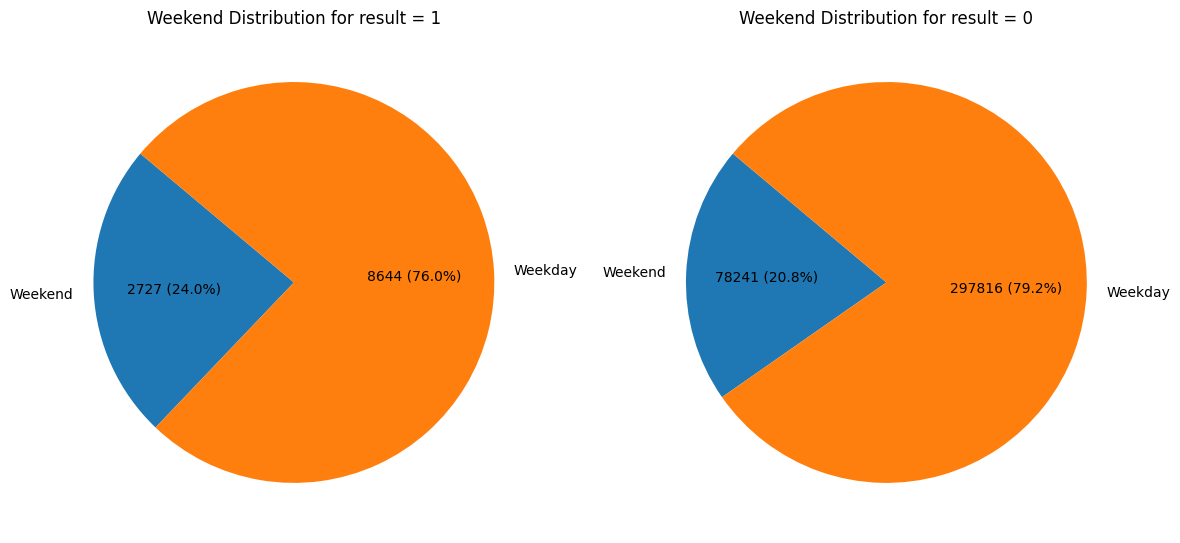

In [19]:
weekend_counts_1 = [
    (data_result_1["weekend"] == 1).sum(),
    (data_result_1["weekend"] == 0).sum(),
]

weekend_counts_0 = [
    (data_result_0["weekend"] == 1).sum(),
    (data_result_0["weekend"] == 0).sum(),
]


labels = ["Weekend", "Weekday"]


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{count} ({pct:.1f}%)"

    return my_autopct


fig, axs = plt.subplots(1, 2, figsize=(12, 6))


axs[0].pie(
    weekend_counts_1,
    labels=labels,
    autopct=make_autopct(weekend_counts_1),
    startangle=140,
)
axs[0].set_title("Weekend Distribution for result = 1")


axs[1].pie(
    weekend_counts_0,
    labels=labels,
    autopct=make_autopct(weekend_counts_0),
    startangle=140,
)
axs[1].set_title("Weekend Distribution for result = 0")


plt.tight_layout()
plt.show()

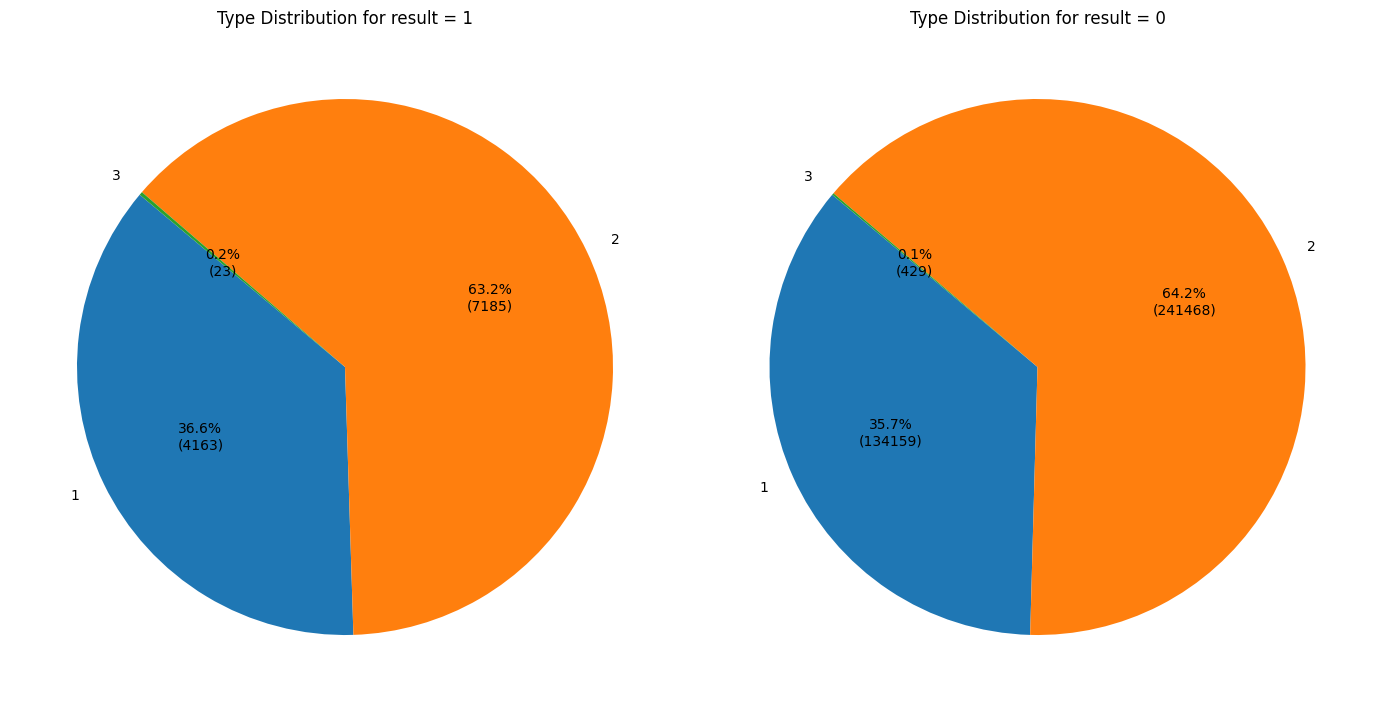

In [20]:
types_result_1 = new_actions[new_actions["result"] == 1]["type"].value_counts()
types_result_0 = new_actions[new_actions["result"] == 0]["type"].value_counts()


for type_val in [1, 2, 3]:
    if type_val not in types_result_1:
        types_result_1[type_val] = 0
    if type_val not in types_result_0:
        types_result_0[type_val] = 0


types_result_1 = types_result_1.sort_index()
types_result_0 = types_result_0.sort_index()


fig, axs = plt.subplots(1, 2, figsize=(14, 7))


axs[0].pie(
    types_result_1,
    labels=types_result_1.index,
    autopct=lambda p: f"{p:.1f}%\n({int(p * sum(types_result_1) / 100)})",
    startangle=140,
)
axs[0].set_title("Type Distribution for result = 1")


axs[1].pie(
    types_result_0,
    labels=types_result_0.index,
    autopct=lambda p: f"{p:.1f}%\n({int(p * sum(types_result_0) / 100)})",
    startangle=140,
)
axs[1].set_title("Type Distribution for result = 0")


plt.tight_layout()
plt.show()

Определим среднее значение времени отклика

In [21]:
data_result_1.time_in_minutes.mean()

np.float64(6.391928297130127)

In [46]:
data_result_0.time_in_minutes.mean()

np.float64(5.265672269540696)

Таким образом, среднее время реакции при положительном результате - 6.4 минуты

In [23]:
top_triggers_result_1 = new_actions[new_actions['result'] == 1]['trigger'].value_counts().head(10)

top_triggers_result_0 = new_actions[new_actions['result'] == 0]['trigger'].value_counts().head(10)


print("Top 10 triggers for result = 1:")
print(top_triggers_result_1)

print("Top 10 triggers for result = 0:")
print(top_triggers_result_0)

Top 10 triggers for result = 1:
trigger
155     896
1793    568
1767    483
1773    457
243     398
187     391
1768    276
1796    182
168     179
2601    165
Name: count, dtype: int64
Top 10 triggers for result = 0:
trigger
155     26636
1793    24717
187     20692
1767    14024
243     12065
1773    11992
1796    10904
2601    10084
6        7520
168      7225
Name: count, dtype: int64


In [22]:
new_actions.head()

,guid,date,closest_date_right,trigger,type,time_in_minutes,weekend,morning,afternoon,evening,night,result
0,018c01fe-9b7d-7b56-9c6b-52f0c7d2b6cc,2024-05-31 08:10:50,2024-05-31 08:05:47,126,1,5.050000,0,1,0,0,0,1
1,0187840b-e302-6b9f-03d5-641e8cda947d,2024-05-31 07:57:24,2024-05-31 07:55:34,243,2,1.833333,0,1,0,0,0,1
2,018c427d-1757-c9d0-04c9-f53957ea11de,2024-05-31 07:10:46,2024-05-31 07:05:56,2149,2,4.833333,0,1,0,0,0,1
3,018cdde9-9bb9-e72e-1743-b5b97e099fab,2024-05-29 04:42:15,2024-05-29 04:40:27,155,2,1.800000,0,0,0,0,1,1
4,018ba14f-56d7-4887-50ef-25a97e4d16f9,2024-05-29 04:23:14,2024-05-29 04:20:20,175,1,2.900000,0,0,0,0,1,1


### Модель и инференс модели

In [31]:
import pandas as pd
import category_encoders as ce
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [32]:
new_actions = pd.read_csv('data/new_actions.csv')

In [34]:
new_actions = new_actions.drop(columns=['guid','date', 'closest_date_right'])

In [35]:
X = new_actions.drop(columns=['result'])
y = new_actions['result']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
encoder = ce.TargetEncoder(cols=['trigger', 'type'])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [38]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

In [39]:
model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)
model.fit(X_train_balanced, y_train_balanced)

/home/userr/projects/casual/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:51:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [40]:
y_pred = model.predict(X_test_encoded)

In [41]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8892703197997057


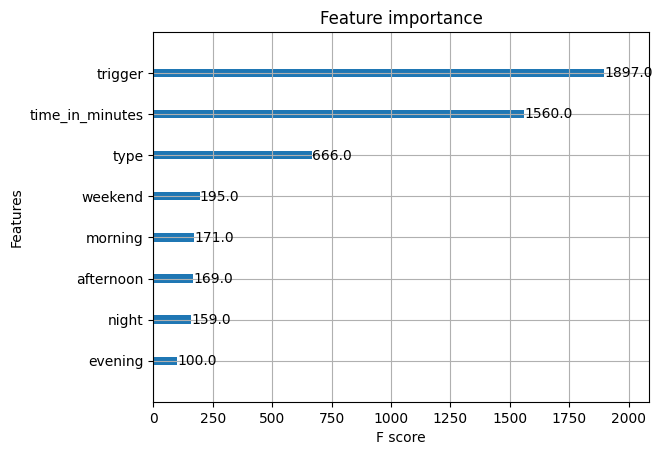

In [42]:
xgb.plot_importance(model)
plt.show()